## Survival Data

In [1]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()

In [2]:
data_x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard


In [3]:
data_x.shape

(137, 6)

In [4]:
data_y.shape

(137,)

In [5]:
data_y[:5]

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [6]:
pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


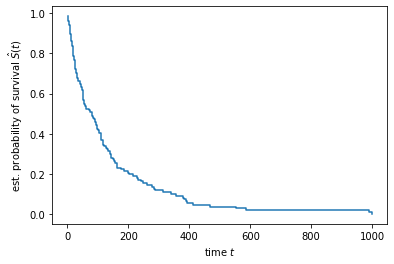

In [8]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y['Status'], data_y['Survival_in_days'])
plt.step(time, survival_prob, where='post')
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$');

## Survival functions by treatment

In [9]:
data_x['Treatment'].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

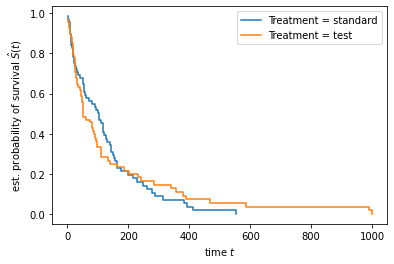

In [10]:
for treatment_type in ('standard', 'test'):
    mask_treat = data_x['Treatment'] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
    data_y['Status'][mask_treat],
    data_y['Survival_in_days'][mask_treat])
    plt.step(time_treatment, survival_prob_treatment, where='post', 
            label = 'Treatment = %s' % treatment_type)
    
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$')
plt.legend(loc='best');

## Survival functions by cell type

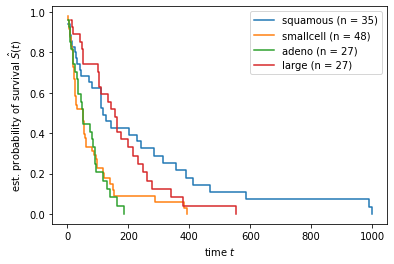

In [11]:
for value in data_x['Celltype'].unique():
    mask = data_x['Celltype'] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y['Status'][mask], 
                                                          data_y['Survival_in_days'][mask])
    plt.step(time_cell, survival_prob_cell, where='post',
            label = '%s (n = %d)' % (value, mask.sum()))

plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$')
plt.legend(loc='best');

## Multivariate Survival Models

In [12]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)

In [13]:
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [14]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [15]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

In [16]:
x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0], 
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]}, 
     columns=data_x_numeric.columns, orient='index')
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


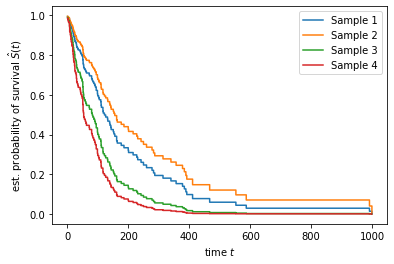

In [17]:
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)

for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where='post', 
            label='Sample %d' % (i+1))
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$')
plt.legend(loc='best');

## Measuring the Performance of Survival Models

In [18]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y['Status'], data_y['Survival_in_days'], prediction)
result[0]

0.7362562471603816

In [19]:
estimator.score(data_x_numeric, data_y)

0.7362562471603816

## Feature Selection: Which Variable is Most Predictive?

In [20]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:,j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [22]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith('_time')]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.716093,0.719862,0.716685,0.717547,0.001655,1,0.732087,0.742432,0.731710,0.735410,0.004968
3,4,{'select__k': 4},0.697368,0.722332,0.727324,0.715675,0.013104,2,0.732477,0.743090,0.727138,0.734235,0.006630
7,8,{'select__k': 8},0.706478,0.723320,0.716685,0.715494,0.006927,3,0.739356,0.746249,0.737519,0.741041,0.003758
5,6,{'select__k': 6},0.704453,0.719368,0.716685,0.713502,0.006491,4,0.735722,0.747565,0.731710,0.738332,0.006731
6,7,{'select__k': 7},0.700405,0.719368,0.720045,0.713272,0.009103,5,0.741173,0.742564,0.728621,0.737453,0.006271
1,2,{'select__k': 2},0.699393,0.717885,0.718365,0.711881,0.008833,6,0.732087,0.727428,0.714409,0.724642,0.007481
0,1,{'select__k': 1},0.698887,0.707510,0.712206,0.706201,0.005516,7,0.710670,0.714793,0.700445,0.708636,0.006032
2,3,{'select__k': 3},0.708502,0.714427,0.694849,0.705926,0.008198,8,0.734034,0.722559,0.716634,0.724409,0.007223


In [23]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

Celltype=large       -0.754714
Celltype=smallcell   -0.328059
Celltype=squamous    -1.147673
Karnofsky_score      -0.031112
Treatment=test        0.257313
dtype: float64

## Evaluating Survival Models

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_flchain
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

plt.rcParams['figure.figsize'] = [7.2, 4.8]

In [25]:
import scipy.optimize as opt

def generate_marker(n_samples, 
                    hazard_ratio, 
                    baseline_hazard, 
                    rnd):
    # create synthetic risk score
    X = rnd.randn(n_samples, 1)
    
    # create linear model
    hazard_ratio = np.array([hazard_ratio])
    logits = np.dot(X, np.log(hazard_ratio))
    
    # draw actual survival times from exponential distribution,
    # refer to Bender et al. (2005), https://doi.org/10.1002/sim.2059
    u = rnd.uniform(size = n_samples)
    time_event = -np.log(u) / (baseline_hazard * np.exp(logits))
    
    # compute the actual concordance in the absence of censoring
    X = np.squeeze(X)
    actual = concordance_index_censored(np.ones(n_samples, dtype=bool), 
                                        time_event, X)
    return X, time_event, actual[0]

def generate_survival_data(n_samples, 
                           hazard_ratio, 
                           baseline_hazard, 
                           percentage_cens, 
                           rnd):
    X, time_event, actual_c = generate_marker(n_samples, hazard_ratio, 
                                              baseline_hazard, rnd)
    def get_observed_time(x):
        rnd_cens = np.random.RandomState(0)
        # draw censoring times
        time_censor = rnd_cens.uniform(high=x, size=n_samples)
        event = time_event < time_censor
        time = np.where(event, time_event, time_censor)
        return event, time
    
    def censoring_amount(x):
        event, _ = get_observed_time(x)
        cens = 1.0 - event.sum() / event.shape[0]
        return (cens - percentage_cens)**2
    
    # search for upper limit to obtain the desired censoring amount
    res = opt.minimize_scalar(censoring_amount, 
                              method='bounded',
                              bounds = (0, time_event.max()))
    # compute observed time
    event, time = get_observed_time(res.x)
    
    # upper time limit such that the probability
    # of being censored is non-zero for `t > tau`
    tau = time[event].max()
    y = Surv.from_arrays(event=event, time=time)
    mask = time < tau
    X_test = X[mask]
    y_test = y[mask]
    
    return X_test, y_test, y, actual_c

def simulation(n_samples, hazard_ratio, n_repeats=100):
    measures = ("censoring", "Harrel's C", "Uno's C",)
    data_mean = {}
    data_std =  {}
    for measure in measures:
        data_mean[measure] = []
        data_std[measure] = []
        
    rnd = np.random.RandomState(seed=987)
    # iterate over different amount of censoring
    for cens in (.1, .25, .4, .5, .6, .7):
        data = {"censoring": [], "Harrel's C": [], "Uno's C": [],}
        for _ in range(n_repeats):
            # generate data
            X_test, y_test, y_train, actual_c = generate_survival_data(
            n_samples, hazard_ratio,
            baseline_hazard=0.1,
            percentage_cens = cens,
            rnd = rnd)
            
            # estimate c-index
            c_harrell = concordance_index_censored(y_test['event'], y_test['time'], X_test)
            c_uno = concordance_index_ipcw(y_train, y_test, X_test)
            
            # save results
            data["censoring"].append(100. - y_test['event'].sum() * 100./y_test.shape[0])
            data["Harrel's C"].append(actual_c - c_harrell[0])
            data["Uno's C"].append(actual_c - c_uno[0])
            
        # aggregate results
        for key, values in data.items():
            data_mean[key].append(np.mean(data[key])) 
            data_std[key].append(np.std(data[key], ddof=1))
            
    data_mean = pd.DataFrame.from_dict(data_mean)
    data_std = pd.DataFrame.from_dict(data_std)
    return data_mean, data_std

def plot_results(data_mean, data_std, **kwargs):
    index = pd.Index(data_mean['censoring'].round(3), name='mean percentage censoring')
    for df in (data_mean, data_std):
        df.drop('censoring', axis=1, inplace=True)
        df.index=index
    ax = data_mean.plot.bar(yerr=data_std, **kwargs)
    ax.set_ylabel('Actual C - Estimated C')
    ax.yaxis.grid(True)
    ax.axhline(0.0, color='gray');

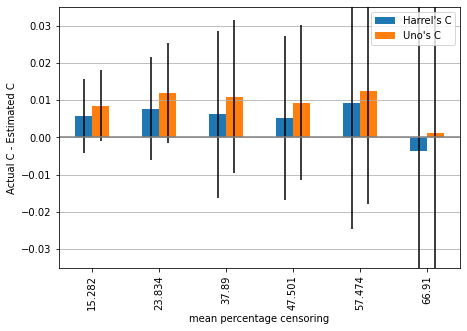

In [26]:
hazard_ratio = 2.0
ylim = [-0.035, 0.035]
mean_1, std_1 = simulation(100, hazard_ratio)
plot_results(mean_1, std_1, ylim=ylim);

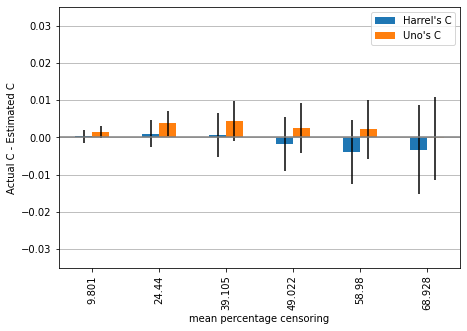

In [27]:
mean_2, std_2 =  simulation(1000, hazard_ratio)
plot_results(mean_2, std_2, ylim=ylim);

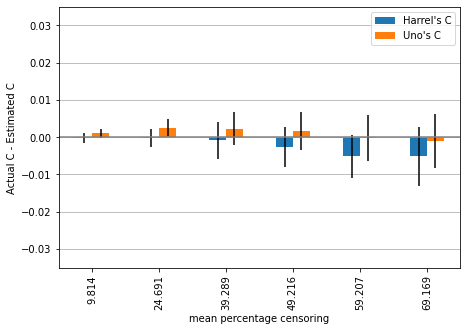

In [28]:
mean_3, std_3 = simulation(2000, hazard_ratio)
plot_results(mean_3, std_3, ylim=ylim);

## Time-dependent Area under the ROC

In [29]:
x, y = load_flchain()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [30]:
num_columns = ['age', 'creatinine', 'kappa', 'lambda']

imputer = SimpleImputer().fit(X_train.loc[:, num_columns])
X_train = imputer.transform(X_train.loc[:, num_columns])
X_test = imputer.transform(X_test.loc[:, num_columns])

In [31]:
y_events = y_train[y_train['death']]
train_min, train_max = y_events['futime'].min(), y_events['futime'].max()

y_events = y_test[y_test['death']]
test_min, test_max = y_events['futime'].min(), y_events['futime'].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

In [32]:
times = np.percentile(y['futime'], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


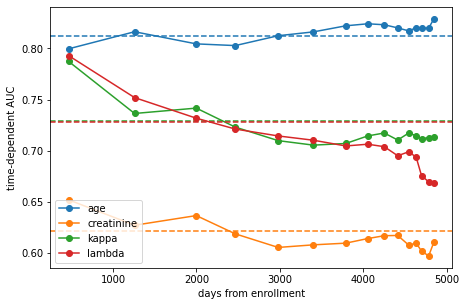

In [33]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    
    plt.plot(times, auc, marker='o', color=color, label=label)
    plt.xlabel('days from enrollment')
    plt.ylabel('time-dependent AUC')
    plt.axhline(mean_auc, color=color, linestyle='--')
    plt.legend()
    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(X_test[:, i], col, color='C{}'.format(i))
    ret = concordance_index_ipcw(y_train, y_test, X_test[:, i], tau = time[-1]);

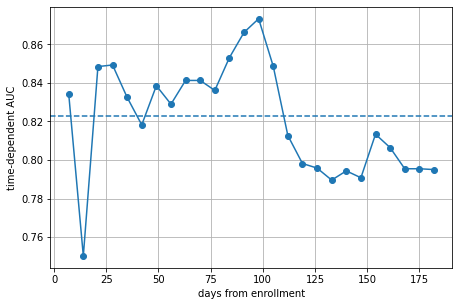

In [34]:
from sksurv.datasets import load_veterans_lung_cancer

va_x, va_y = load_veterans_lung_cancer()

cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(va_x, va_y)

va_times = np.arange(7, 183, 7)
# estimate performance on training data, thus use `va_y` twice
va_auc, va_mean_auc = cumulative_dynamic_auc(va_y, va_y, cph.predict(va_x), va_times)

plt.plot(va_times, va_auc, marker='o')
plt.axhline(va_mean_auc, linestyle='--')
plt.xlabel('days from enrollment')
plt.ylabel('time-dependent AUC')
plt.grid(True);

## Penalized Cox Models

In [35]:
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [36]:
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size
0,10.93,8.96,11.63,10.96,11.52,12.04,9.62,9.81,10.02,7.85,...,10.13,10.93,6.48,5.99,57.0,0.0,0.0,1.0,0.0,3.0
1,12.24,9.53,12.63,11.59,12.32,10.78,10.60,10.70,10.16,8.74,...,10.21,9.56,4.97,7.05,57.0,1.0,0.0,1.0,0.0,3.0
2,11.66,10.24,12.57,9.17,11.70,11.35,9.38,10.16,10.03,8.13,...,10.16,9.31,4.28,6.83,48.0,0.0,0.0,1.0,0.0,2.5
3,12.17,9.82,12.11,9.09,13.13,11.86,8.40,8.67,10.73,8.65,...,10.66,10.21,5.71,6.93,42.0,1.0,0.0,1.0,0.0,1.8
4,11.48,11.49,11.78,8.89,10.43,11.40,7.74,8.64,9.56,8.48,...,11.57,10.93,5.82,6.66,46.0,1.0,1.0,0.0,0.0,3.0


In [37]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas: 
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_
    
coefficients = (pd.DataFrame
  .from_dict(coefficients)
  .rename_axis(index='feature', columns='alpha')
  .set_index(Xt.columns))

In [38]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], '.-', label=row.Index)
    
    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + ' ', 
            horizontalalignment = 'right',
            verticalalignment = 'center'
        )
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel('alpha')
    ax.set_ylabel('coefficient')

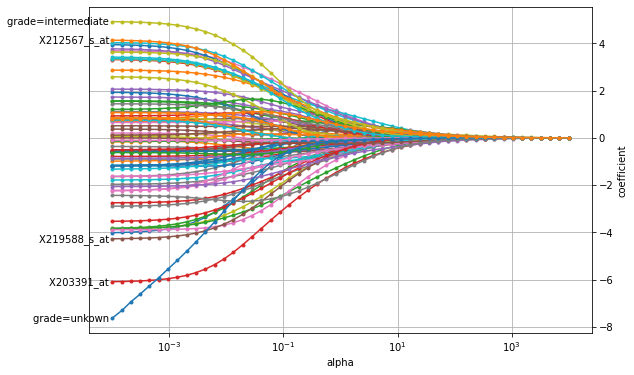

In [39]:
plot_coefficients(coefficients, n_highlight=5);

## LASSO

In [40]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

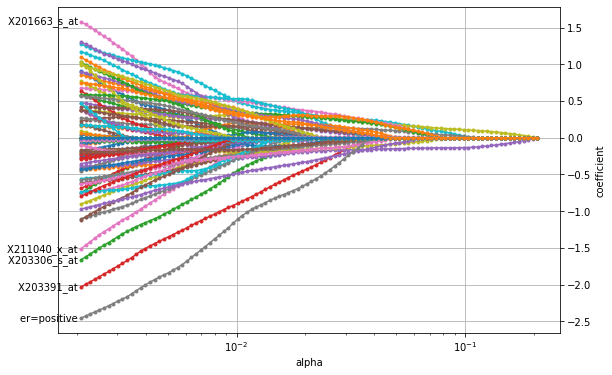

In [41]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=Xt.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)
plot_coefficients(coefficients_lasso, n_highlight=5);

## Elastic Net

In [42]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

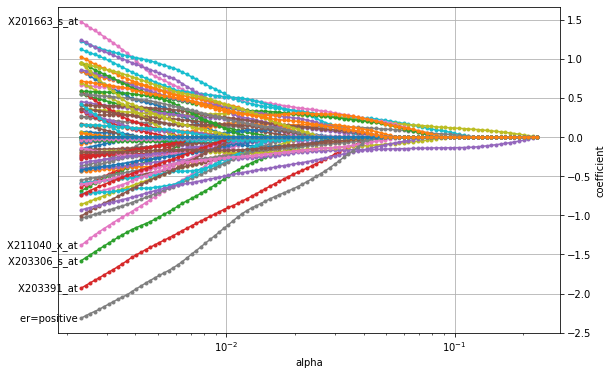

In [43]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, 
    index=Xt.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)
plot_coefficients(coefficients_elastic_net, n_highlight=5)

## Choosing penalty strength α

In [44]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter('ignore', ConvergenceWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [45]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

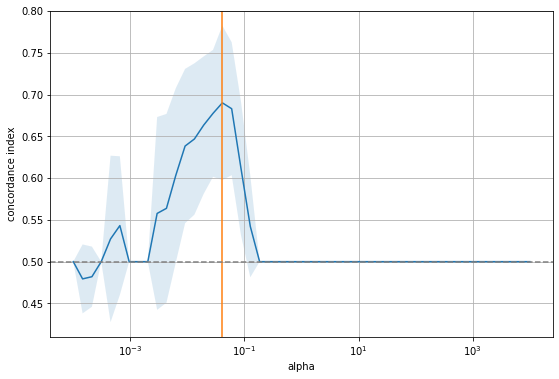

In [46]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean-std, mean+std, alpha=0.15)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('concordance index')
ax.axvline(gcv.best_params_['coxnetsurvivalanalysis__alphas'][0], c='C1')
ax.axhline(0.5, color='grey', linestyle='--')
ax.grid(True);

Number of non-zero coefficients: 21


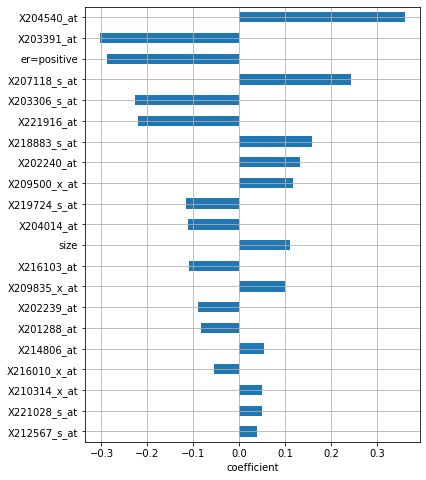

In [47]:
best_model = gcv.best_estimator_.named_steps['coxnetsurvivalanalysis']
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=['coefficient']
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print('Number of non-zero coefficients: {}'.format(non_zero))

non_zero_coefs = best_coefs.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').index
_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel('coefficient')
ax.grid(True);

## Survival and Cumulative Hazard Function

In [48]:
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.040949150623804234],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

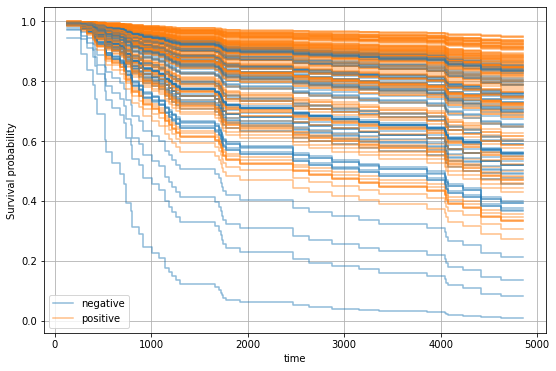

In [49]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y['t.tdm'], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, Xt.loc[:, 'er=positive'].astype(int)):
    line, = ax.step(time_points, fn(time_points), where='post',
                   color='C{:d}'.format(label), alpha=0.5)
    if len(legend_handles) <= label:
        name = 'positive' if label == 1 else 'negative'
        legend_labels.append(name)
        legend_handles.append(line)
        
ax.legend(legend_handles, legend_labels)
ax.set_xlabel('time')
ax.set_ylabel('Survival probability')
ax.grid(True);

## Using Random Survival Forests

In [50]:
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [51]:
X, y = load_gbsg2()

In [52]:
grade_str = X.loc[:, 'tgrade'].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[['I', 'II', 'III']]).fit_transform(grade_str)

X_no_grade = X.drop('tgrade', axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt = np.column_stack((Xt.values, grade_num))

feature_names = X_no_grade.columns.tolist() + ['tgrade']

In [53]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

## Training

In [54]:
rsf = RandomSurvivalForest(n_estimators=1000, 
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features='sqrt',
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [55]:
rsf.score(X_test, y_test)

0.6759696016771488

## Predicting

In [56]:
a = np.empty(X_test.shape[0], dtype=[('age', float), ('pnodes', float)])
a['age'] = X_test[:, 0]
a['pnodes'] = X_test[:, 4]

sort_idx = np.argsort(a, order=['pnodes', 'age'])
X_test_sel = pd.DataFrame(
    X_test[np.concatenate((sort_idx[:3], sort_idx[-3:]))],
    columns=feature_names)

X_test_sel

,age,estrec,horTh,menostat,pnodes,progrec,tsize,tgrade
0,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0
1,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
2,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0
3,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
4,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
5,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0


In [57]:
pd.Series(rsf.predict(X_test_sel))

0     91.477609
1    102.897552
2     75.883786
3    170.502092
4    171.210066
5    148.691835
dtype: float64

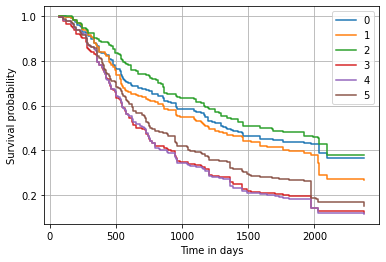

In [58]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where='post', label=str(i))
plt.xlabel('Time in days')
plt.ylabel('Survival probability')
plt.legend()
plt.grid(True);

## Permutation-based Feature Importance

In [59]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

Using TensorFlow backend.


Weight,Feature
0.0676 ± 0.0229,pnodes
0.0206 ± 0.0139,age
0.0177 ± 0.0468,progrec
0.0086 ± 0.0098,horTh
0.0032 ± 0.0198,tsize
0.0032 ± 0.0060,tgrade
-0.0007 ± 0.0018,menostat
-0.0063 ± 0.0207,estrec


## Gradient Boosted Models

### Base Learners

### Losses 

Cox’s Partial Likelihood

In [60]:
from sklearn.model_selection import train_test_split
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [61]:
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=0)

In [62]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.756


In [63]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

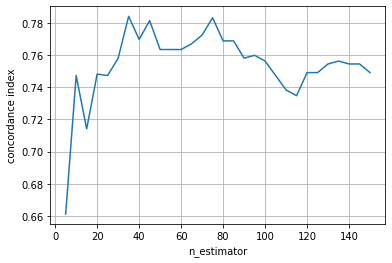

In [64]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.grid(True);

In [65]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

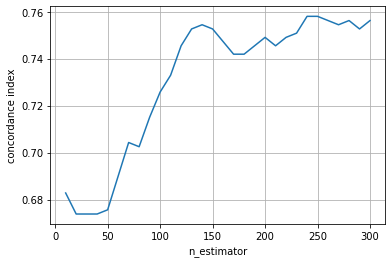

In [66]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.grid(True);

In [67]:
coef = pd.Series(est_cph_ls.coef_, ['Intercept'] + Xt.columns.tolist())

print('Number of non-zero coefficients:', (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 9


er=positive          -0.837549
X207118_s_at          0.239161
grade=unkown         -0.234126
size                  0.214384
X204540_at            0.094421
X204014_at           -0.091377
X216103_at           -0.086147
X221916_at           -0.081565
grade=intermediate    0.065916
dtype: float64

## Accelerated Failure Time Model

In [68]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss='ipcwls', n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

0.722


## Regularization

In [69]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    'no regularization': GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, max_depth=1, random_state=0
    ),
    'learning rate': GradientBoostingSurvivalAnalysis(
        learning_rate=0.1, max_depth=1, random_state=0
    ),
    'dropout': GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0
    ),
    'subsample': GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0
    ),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex=est.score(X_test, y_test)
        scores_reg[name].append(cindex)
        
scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

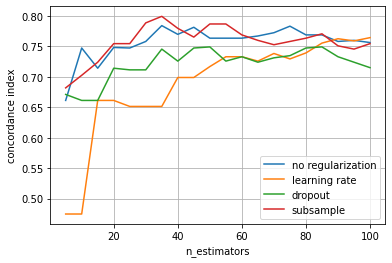

In [70]:
ax = scores_reg.plot(xlabel='n_estimators', ylabel='concordance index')
ax.grid(True);

In [71]:
class EarlyStoppingMonitor:
    
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1
        
    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False
        
        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])
        
        if improvement > 1e-6:
            self._best_step = iteration
            return False
        
        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement
    
est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5,
    max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)
est_early_stopping.fit(X_train, y_train, monitor=monitor)

print('Fitted base learners:', est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print('Performance on test set', round(cindex, 3))

Fitted base learners: 119
Performance on test set 0.703


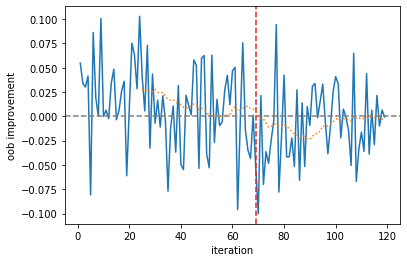

In [72]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_,
    index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel='iteration', ylabel='oob improvement')
ax.axhline(0.0, linestyle='--', color='gray')
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle='--', color='C3')

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=':')

# Linear Survival Support Vector Machine

In [73]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

/opt/tljh/user/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [74]:
data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

In [75]:
n_censored = y.shape[0] - y['Status'].sum()
print('%.1f%% of records are censored' % (n_censored / y.shape[0] * 100))

6.6% of records are censored


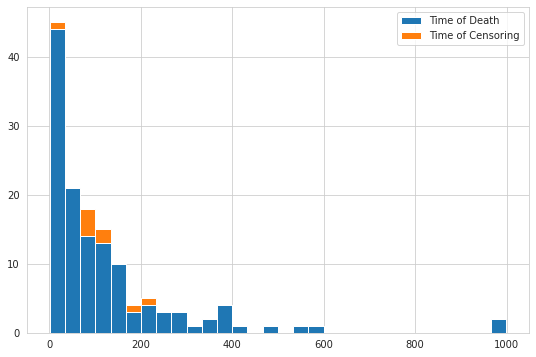

In [76]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((y['Survival_in_days'][y['Status']],
                               y['Survival_in_days'][~y['Status']]),
                               bins=30, stacked=True)
_ = plt.legend(patches, ['Time of Death', 'Time of Censoring']);

In [77]:
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

In [78]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['Status'], y['Survival_in_days'], prediction)
    return result[0]

In [79]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model, 
                   n_jobs=4, refit=False, 
                   cv=cv)

In [80]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
gcv = gcv.fit(x, y)

In [81]:
round(gcv.best_score_, 3), gcv.best_params_

(0.72, {'alpha': 0.00390625})

In [82]:
def plot_performance(gcv):
    n_splits=gcv.cv.n_splits
    cv_scores={'alpha': [], 'test_score': [], 'split': []}
    order = []
    for i, params in enumerate(gcv.cv_results_['params']):
        name = '%.5f' % params['alpha']
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_['split%d_test_score' % j][i]
            cv_scores['alpha'].append(name)
            cv_scores['test_score'].append(vs)
            cv_scores['split'].append(j)
    df = pd.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x='alpha', y='test_score', data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation('vertical')

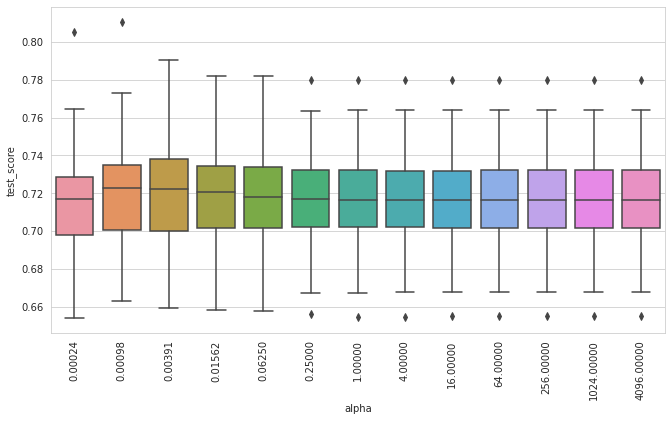

In [83]:
plot_performance(gcv)

In [84]:
estimator.set_params(**gcv.best_params_)
estimator.fit(x, y)

FastSurvivalSVM(alpha=0.00390625, max_iter=1000, optimizer='avltree',
                random_state=0, tol=1e-05)

In [86]:
pred = estimator.predict(x.iloc[:2])
print(np.round(pred, 3))
print(y[:2])

[-1.59  -1.687]
[( True,  72.) ( True, 411.)]


## Regression Objective

In [87]:
y_log_t = y.copy()
y_log_t['Survival_in_days'] = np.log1p(y['Survival_in_days'])

In [88]:
ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(x, y_log_t)

cindex = concordance_index_censored(
    y['Status'],
    y['Survival_in_days'],
    -ref_estimator.predict(x),
)
print(round(cindex[0], 3))

0.724


In [89]:
pred_log = ref_estimator.predict(x.iloc[:2])
pred_y = np.expm1(pred_log)
print(np.round(pred_y, 3))

[106.683 131.105]


## Kernel Survival Support Vector Machine

In [90]:
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM

In [91]:
kernel_matrix = clinical_kernel(data_x)

In [92]:
kssvm = FastKernelSurvivalSVM(optimizer='rbtree', kernel='precomputed', random_state=0)

kgcv = GridSearchCV(kssvm, param_grid, scoring=score_survival_model, n_jobs=4, refit=False, cv=cv)

In [94]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
kgcv = kgcv.fit(kernel_matrix, y)

In [95]:
round(kgcv.best_score_, 3), kgcv.best_params_

(0.709, {'alpha': 0.015625})

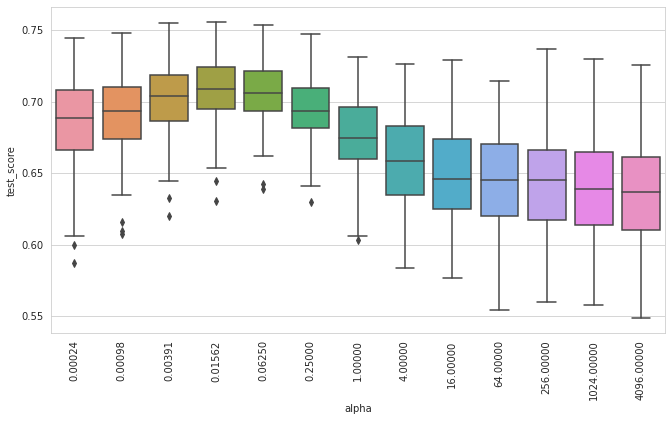

In [97]:
plot_performance(kgcv)